# News Classifier
NLP and RandomForest

## Import the necessary libraries

In [14]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Load dataset

In [15]:
testing_path = './datasets/testing_data_lowercase_nolabels.csv'
training_path = './datasets/training_data_lowercase.csv'

In [16]:
df_testing = pd.read_csv(testing_path, sep='\t', header=None)
df_training = pd.read_csv(training_path, sep='\t', header=None)

## Clean-up data
In this step we're cleaning up the training data and the testing data

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

def clean_text(text):
    # Removing punctuation
    text_no_punct = text.translate(translator)
    
    # Tokenize (split into words)
    tokens = word_tokenize(text_no_punct)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = []
    for word in tokens:
        if word.lower() not in stop_words: # Check if it's a stopword
            lemma = lemmatizer.lemmatize(word) # Get root form
            cleaned_tokens.append(lemma)
            
    # Join back to a string
    return " ".join(cleaned_tokens)

In [4]:
df_training.columns = ['label', 'text']
df_training['text'] = df_training['text'].fillna('')
df_training['cleaned_text'] = df_training['text'].apply(clean_text)

## Split the training data
Here we're spliting the data into X_tain and y_train

In [5]:
X_train_full = df_training['cleaned_text']
y_train_full = df_training['label'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

## Vectorize data

In [6]:
validation_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf_val = validation_vectorizer.fit_transform(X_train)
X_val_tfidf = validation_vectorizer.transform(X_val)
print(X_val_tfidf.shape)

(6831, 5000)


## Validation Model (Random Forest)

In [7]:
rf_model_val = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100
)
rf_model_val.fit(X_train_tfidf_val, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Validation Model Evaluation

Accuracy: 0.9136

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3515
           1       0.91      0.91      0.91      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831


Confusion Matrix:
[[3208  307]
 [ 283 3033]]


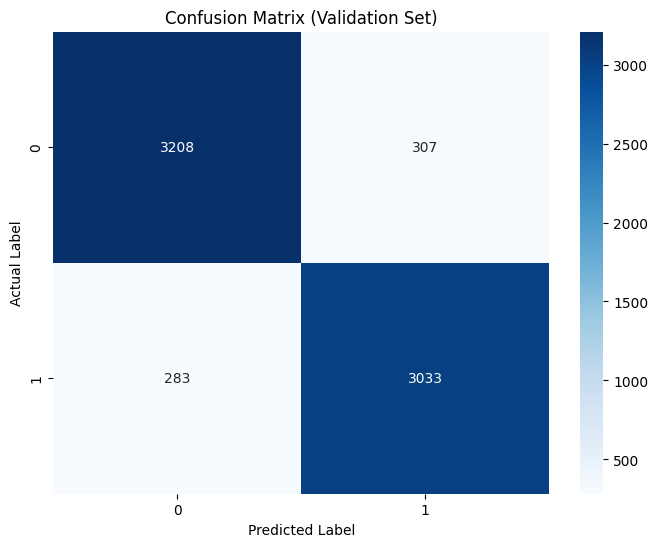

In [8]:
val_predictions = rf_model_val.predict(X_val_tfidf)

accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, val_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_train_full), 
            yticklabels=np.unique(y_train_full))
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Vectorize Data for the Final Model

In [9]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_full_tfidf = vectorizer.fit_transform(X_train_full)
print(f"\nFull training data TF-IDF shape: {X_train_full_tfidf.shape}")


Full training data TF-IDF shape: (34152, 5000)


## Classifier Model (Random Forest)

### Train Model

In [ ]:
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100
)

rf_model.fit(X_train_full_tfidf, y_train_full)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Clean up the Test data

In [11]:
df_testing.columns = ['id', 'text']
df_testing['text'] = df_testing['text'].fillna('')
df_testing['cleaned_text'] = df_testing['text'].apply(clean_text)
df_testing['cleaned_text']

0        copycat muslim terrorist arrested assault weapon
1       wow chicago protester caught camera admits vio...
2               germany fdp look fill schaeubles big shoe
3       mi school sends welcome back packet warning ki...
4       un seek massive aid boost amid rohingya emerge...
                              ...                        
9979    boom fox news leftist chris wallace attempt tr...
9980    list democrat hypocrite voted filibuster gw bu...
9981    new fire ravage rohingya village northwest mya...
9982    meal wheel shuts lyin‚ lefty truth moveonorg‚s...
9983    brilliant tucker carlson ayaan hirsi ali discu...
Name: cleaned_text, Length: 9984, dtype: object

## Making Predictions

In [12]:
X_test_tfidf = vectorizer.transform(df_testing['cleaned_text'])
test_predictions = rf_model.predict(X_test_tfidf)

## Saving predictions into a CSV

In [13]:
submission_df = pd.DataFrame({
    'id': df_testing['id'],
    'text': df_testing['text'],
    'label': test_predictions
})

submission_filename = './datasets/final_predictions.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission file saved as '{submission_filename}'")
print("\nHead of the submission file:")
print(submission_df.head())


Submission file saved as './datasets/final_predictions.csv'

Head of the submission file:
  id                                               text  label
0  2  copycat muslim terrorist arrested with assault...      0
1  2  wow! chicago protester caught on camera admits...      0
2  2   germany's fdp look to fill schaeuble's big shoes      1
3  2  mi school sends welcome back packet warning ki...      0
4  2  u.n. seeks 'massive' aid boost amid rohingya '...      1
